Dane pochodzą z Kaggle:
https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses

In [192]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape

In [2]:
aviation = pd.read_csv("AviationData.csv", encoding='latin-1', low_memory=False)
# df = pd.read_csv("USState_Codes.csv")

In [3]:

pd.set_option('display.max_columns', None)
aviation.shape

(88889, 31)

In [ ]:
aviation.head()

In [ ]:
aviation.sample(10)

In [ ]:
aviation.tail()

In [4]:
#creating a copy of original dataframe
original_aviation = aviation.copy()

In [5]:
aviation.keys()

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

In [6]:
#listing columns that contain Nans (as there are 27 columns that are incomplete, there is a need to consider how to handle the issue )
missing_data_col = aviation.columns[aviation.isna().any()].tolist()
missing_data_col, len(missing_data_col)

(['Location',
  'Country',
  'Latitude',
  'Longitude',
  'Airport.Code',
  'Airport.Name',
  'Injury.Severity',
  'Aircraft.damage',
  'Aircraft.Category',
  'Registration.Number',
  'Make',
  'Model',
  'Amateur.Built',
  'Number.of.Engines',
  'Engine.Type',
  'FAR.Description',
  'Schedule',
  'Purpose.of.flight',
  'Air.carrier',
  'Total.Fatal.Injuries',
  'Total.Serious.Injuries',
  'Total.Minor.Injuries',
  'Total.Uninjured',
  'Weather.Condition',
  'Broad.phase.of.flight',
  'Report.Status',
  'Publication.Date'],
 27)

In [7]:
#creating a function removing columns with missing data above established threshold and listing the removed columns

def drop_columns(df, thr = 0.5):
    missing_percentages = df.isna().mean()
    col_to_drop = missing_percentages[missing_percentages > thr].index
    new_df=df.drop(columns = col_to_drop)
    return new_df, list(col_to_drop)
    
    

In [8]:
# there are 6 columns to be removed when threshold 0.5 is applied
dropped_col_df, dropped_columns = drop_columns(aviation, 0.5)
dropped_columns

['Latitude',
 'Longitude',
 'Aircraft.Category',
 'FAR.Description',
 'Schedule',
 'Air.carrier']

In [9]:
# there are 8 columns to be removed when threshold 0.4 is applied
dropped_col_df, dropped_columns = drop_columns(aviation, 0.4)
dropped_columns

['Latitude',
 'Longitude',
 'Airport.Code',
 'Airport.Name',
 'Aircraft.Category',
 'FAR.Description',
 'Schedule',
 'Air.carrier']

In [10]:
dropped_col_df.shape

(88889, 23)

In [11]:
#I decide to perform an analysis applying the threshold 0.4.

dropped_col_df

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,Fatal(2),Destroyed,NC6404,Stinson,108-3,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Fatal(4),Destroyed,N5069P,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,Fatal(3),Destroyed,N5142R,Cessna,172M,No,1.0,Reciprocating,Personal,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,Fatal(2),Destroyed,N1168J,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,Fatal(1),Destroyed,N15NY,Cessna,501,No,NaN,NaN,Personal,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88884,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,Minor,NaN,N1867H,PIPER,PA-28-151,No,NaN,NaN,Personal,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022
88885,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,N2895Z,BELLANCA,7ECA,No,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88886,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,Non-Fatal,Substantial,N749PJ,AMERICAN CHAMPION AIRCRAFT,8GCBC,No,1.0,NaN,Personal,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022
88887,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,N210CU,CESSNA,210N,No,NaN,NaN,Personal,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [12]:

dropped_col_df["Death.Ratio"] =  dropped_col_df["Total.Fatal.Injuries"]/(dropped_col_df["Total.Fatal.Injuries"] + dropped_col_df["Total.Serious.Injuries"]+ dropped_col_df["Total.Minor.Injuries"]+ dropped_col_df["Total.Uninjured"])

In [13]:

# For numerical variables the missing data will be replaced with a mean, but firstly let's check the number of missing values.


from tabulate import tabulate

def check_missing_values(df):
    pd.set_option('display.max_rows', None)
    print("The number of missing values in each column:")
    table_data = []
    for column in df.columns:
        missing_count = df[column].isna().sum()
        table_data.append([column, missing_count])

    print(tabulate(table_data, headers = ["Column", "No. of missing values"], tablefmt = "grid"))

    pd.reset_option('display.max_rows', None)

In [14]:
check_missing_values(dropped_col_df)

The number of missing values in each column:
+------------------------+-------------------------+
| Column                 |   No. of missing values |
+========================+=========================+
| Event.Id               |                       0 |
+------------------------+-------------------------+
| Investigation.Type     |                       0 |
+------------------------+-------------------------+
| Accident.Number        |                       0 |
+------------------------+-------------------------+
| Event.Date             |                       0 |
+------------------------+-------------------------+
| Location               |                      52 |
+------------------------+-------------------------+
| Country                |                     226 |
+------------------------+-------------------------+
| Injury.Severity        |                    1000 |
+------------------------+-------------------------+
| Aircraft.damage        |                    3194 |
+

In [ ]:
# dropped_col_df["Total.Fatal.Injuries"].fillna(dropped_col_df["Total.Fatal.Injuries"].mean(), inplace = True)
# dropped_col_df["Total.Serious.Injuries"].fillna(dropped_col_df["Total.Serious.Injuries"].mean(), inplace = True)
# dropped_col_df["Total.Minor.Injuries"].fillna(dropped_col_df["Total.Minor.Injuries"].mean(), inplace = True)
# dropped_col_df["Total.Uninjured"].fillna(dropped_col_df["Total.Uninjured"].mean(), inplace = True)

# dropped_col_df["Location"].fillna('Unknown', inplace = True)
# dropped_col_df["Country"].fillna('Unknown', inplace = True)
# dropped_col_df["Injury.Severity"].fillna('Unknown', inplace = True)
# dropped_col_df["Aircraft.damage"].fillna('Unknown', inplace = True)
# dropped_col_df["Registration.Number"].fillna('Unknown', inplace = True)
# dropped_col_df["Make"].fillna('Unknown', inplace = True)
# dropped_col_df["Model"].fillna('Unknown', inplace = True)
# dropped_col_df["Amateur.Built"].fillna('Unknown', inplace = True)
# dropped_col_df["Number.of.Engines"].fillna('Unknown', inplace = True)
# dropped_col_df["Engine.Type"].fillna('Unknown', inplace = True)
# dropped_col_df["Purpose.of.flight"].fillna('Unknown', inplace = True)
# dropped_col_df["Weather.Condition"].fillna('Unknown', inplace = True)
# dropped_col_df["Broad.phase.of.flight"].fillna('Unknown', inplace = True)
# dropped_col_df["Report.Status"].fillna('Unknown', inplace = True)
# dropped_col_df["Publication.Date"].fillna('Unknown', inplace = True)


In [15]:
#changing date (presented as string) to date format 
dropped_col_df["Event.Date"] = pd.to_datetime(dropped_col_df["Event.Date"])

In [60]:
#the DataFrame without any nans (all the missing values have been removed)

dropped_col_df = dropped_col_df.dropna()
dropped_col_df["Year"] = dropped_col_df["Event.Date"].dt.year
dropped_col_df["Month"] = dropped_col_df["Event.Date"].dt.month
dropped_col_df.head(5)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Death.Ratio,Year,Month
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Fatal(4),Destroyed,N5069P,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1.0,1962,7
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,Fatal(2),Destroyed,N1168J,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1.0,1977,6
6,20001218X45446,Accident,CHI81LA106,1981-08-01,"COTTON, MN",United States,Fatal(4),Destroyed,N4988E,Cessna,180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,IMC,Unknown,Probable Cause,06-11-2001,1.0,1981,8
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,N2482N,Cessna,140,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,0.0,1982,1
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,N7967Q,Cessna,401B,No,2.0,Reciprocating,Business,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,0.0,1982,1


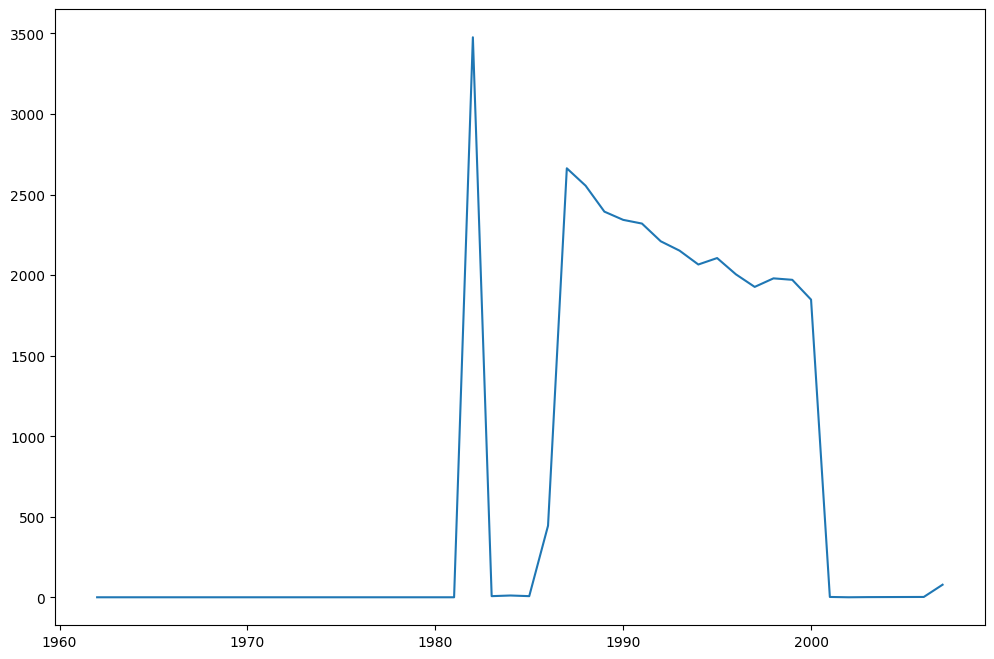

In [17]:
#data visualisation

accidents_by_year = dropped_col_df["Year"].value_counts().sort_index()


plt.figure(figsize=(12,8))
plt.plot(accidents_by_year.index, accidents_by_year.values)

In [18]:
original_aviation["Event.Date"] = pd.to_datetime(original_aviation["Event.Date"])
original_aviation["Year"] = original_aviation["Event.Date"].dt.year
original_aviation_1982 = original_aviation[original_aviation["Year"] >=1982]
accidents_by_year_original = original_aviation["Year"].value_counts().sort_index()
accidents_by_year_1982 = original_aviation_1982["Year"].value_counts().sort_index()

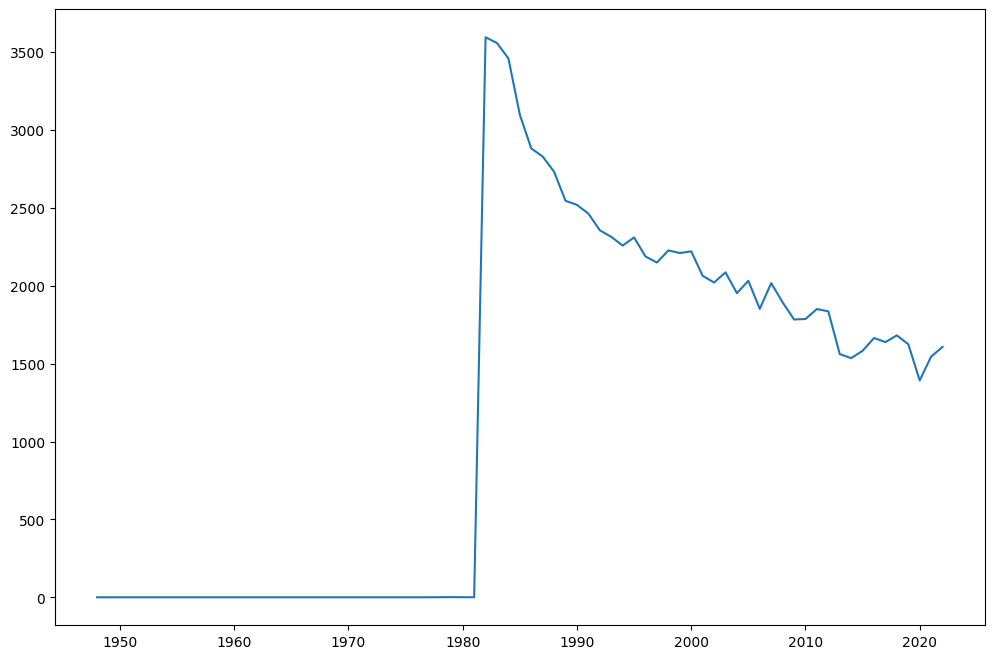

In [19]:

plt.figure(figsize=(12,8))
plt.plot(accidents_by_year_original.index, accidents_by_year_original.values)

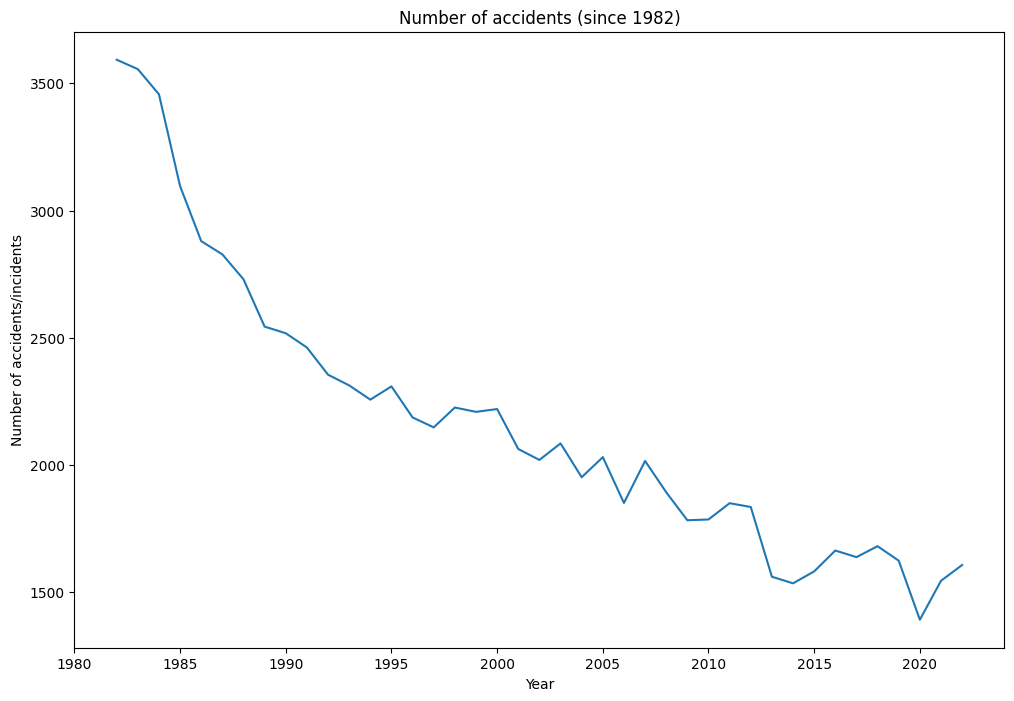

In [23]:
plt.figure(figsize=(12,8))
plt.plot(accidents_by_year_1982.index, accidents_by_year_1982.values)
plt.xlabel("Year")
plt.ylabel("Number of accidents/incidents")
plt.title("Number of accidents (since 1982)")
plt.show()

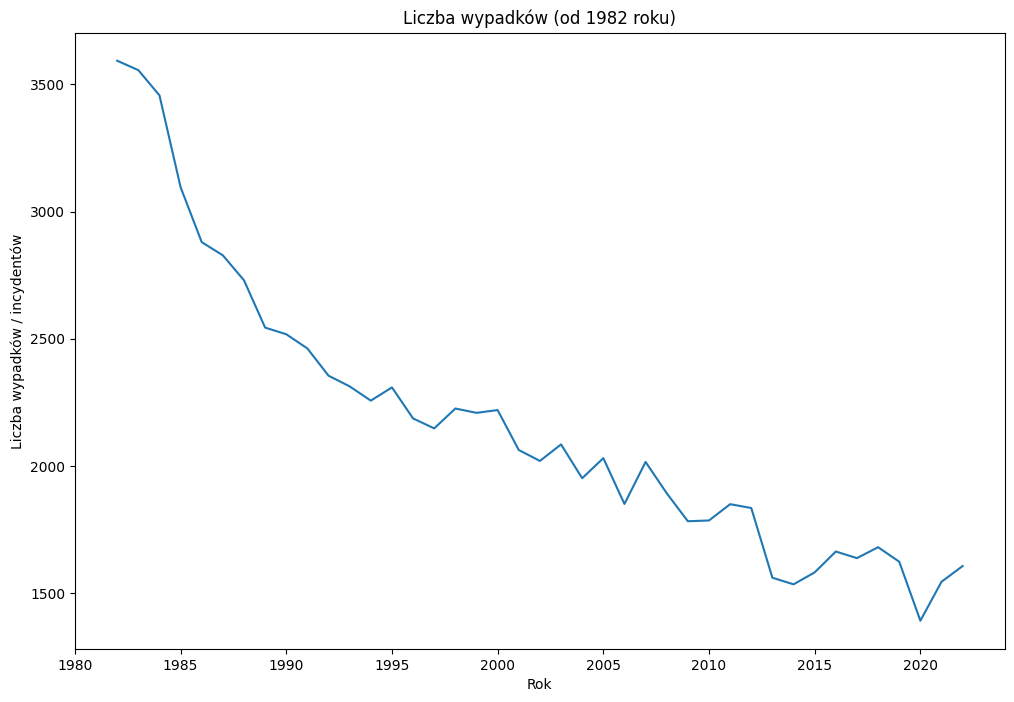

In [24]:
plt.figure(figsize=(12,8))
plt.plot(accidents_by_year_1982.index, accidents_by_year_1982.values)
plt.xlabel("Rok")
plt.ylabel("Liczba wypadków / incydentów")
plt.title("Liczba wypadków (od 1982 roku)")
plt.show()

In [25]:
df_usa = dropped_col_df[dropped_col_df["Country"] == "United States"]

In [26]:
import us

all_states = us.states.STATES

for state in all_states:
    print(state)

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


In [27]:
state_abbr = [state.abbr for state in all_states]
state_abbr

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

In [28]:
df_usa["State"] = df_usa["Location"].str[-2:]
df_usa

/tmp/ipykernel_30642/1412933157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa["State"] = df_usa["Location"].str[-2:]


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Death.Ratio,Year,State
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Fatal(4),Destroyed,N5069P,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1.0,1962,CA
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,Fatal(2),Destroyed,N1168J,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1.0,1977,CA
6,20001218X45446,Accident,CHI81LA106,1981-08-01,"COTTON, MN",United States,Fatal(4),Destroyed,N4988E,Cessna,180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,IMC,Unknown,Probable Cause,06-11-2001,1.0,1981,MN
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,N2482N,Cessna,140,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,0.0,1982,WA
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,N7967Q,Cessna,401B,No,2.0,Reciprocating,Business,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,0.0,1982,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63893,20080104X00022,Accident,MIA08LA032,2007-12-26,"SARASOTA, FL",United States,Non-Fatal,Substantial,N5875Q,Mooney,M20E,No,1.0,Reciprocating,Personal,0.0,0.0,2.0,0.0,VMC,Takeoff,Probable Cause,14-01-2009,0.0,2007,FL
63896,20071231X02008,Incident,DEN08IA044,2007-12-26,"Aspen, CO",United States,Incident,Minor,N47BC,Piper,PA-46-310P,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,4.0,VMC,Climb,Probable Cause,24-12-2008,0.0,2007,CO
63900,20080102X00006,Accident,SEA08LA054,2007-12-28,"MURRIETA, CA",United States,Non-Fatal,Substantial,N365SX,Hein,Sonex,Yes,1.0,Reciprocating,Personal,0.0,1.0,0.0,0.0,VMC,Cruise,Probable Cause,24-12-2008,0.0,2007,CA
63906,20080103X00010,Accident,DFW08LA052,2007-12-29,"Crowley, TX",United States,Fatal(2),Destroyed,N136DG,Althouse,RAF 2000 GTX,Yes,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,VMC,Maneuvering,Probable Cause,03-12-2008,1.0,2007,TX


In [29]:
df_usa

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Death.Ratio,Year,State
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Fatal(4),Destroyed,N5069P,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1.0,1962,CA
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,Fatal(2),Destroyed,N1168J,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1.0,1977,CA
6,20001218X45446,Accident,CHI81LA106,1981-08-01,"COTTON, MN",United States,Fatal(4),Destroyed,N4988E,Cessna,180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,IMC,Unknown,Probable Cause,06-11-2001,1.0,1981,MN
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,N2482N,Cessna,140,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,0.0,1982,WA
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,N7967Q,Cessna,401B,No,2.0,Reciprocating,Business,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,0.0,1982,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63893,20080104X00022,Accident,MIA08LA032,2007-12-26,"SARASOTA, FL",United States,Non-Fatal,Substantial,N5875Q,Mooney,M20E,No,1.0,Reciprocating,Personal,0.0,0.0,2.0,0.0,VMC,Takeoff,Probable Cause,14-01-2009,0.0,2007,FL
63896,20071231X02008,Incident,DEN08IA044,2007-12-26,"Aspen, CO",United States,Incident,Minor,N47BC,Piper,PA-46-310P,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,4.0,VMC,Climb,Probable Cause,24-12-2008,0.0,2007,CO
63900,20080102X00006,Accident,SEA08LA054,2007-12-28,"MURRIETA, CA",United States,Non-Fatal,Substantial,N365SX,Hein,Sonex,Yes,1.0,Reciprocating,Personal,0.0,1.0,0.0,0.0,VMC,Cruise,Probable Cause,24-12-2008,0.0,2007,CA
63906,20080103X00010,Accident,DFW08LA052,2007-12-29,"Crowley, TX",United States,Fatal(2),Destroyed,N136DG,Althouse,RAF 2000 GTX,Yes,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,VMC,Maneuvering,Probable Cause,03-12-2008,1.0,2007,TX


In [30]:
# A heatmap visualising the distribution of aviation accidents around the US
state_counts = df_usa['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

import plotly.express as px
fig = px.choropleth(
    state_counts,
    locations="State",
    locationmode="USA-states",
    color="Count",
    scope="usa",
    title="Distribution of accidents in USA",
    color_continuous_scale= 'Blues',
)


fig.show()

In [52]:
# A heatmap visualising the distribution of aviation accidents around the US
state_counts = df_usa['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Liczba wypadków']

import plotly.express as px
fig = px.choropleth(
    state_counts,
    locations="State",
    locationmode="USA-states",
    color="Liczba wypadków",
    scope="usa",
    title="Rozkład wypadków w Stanach Zjednoczonych Ameryki",
    color_continuous_scale= 'Blues',
)

fig.update_layout(
    title=dict(
        x=0.5,  # Ustawienie położenia tytułu na osi X w środku wykresu
        y=0.85,  # Ustawienie położenia tytułu na osi Y nad wykresem
        xanchor='center',  # Ustawienie kotwicy na środek
        yanchor='top'  # Ustawienie kotwicy na górę
    ),
      legend=dict(
        x=0.3,  # Ustawienie położenia legendy na osi X w środku wykresu
        y=1.02,  # Ustawienie położenia legendy na osi Y nieco powyżej wykresu
        xanchor='left',  # Ustawienie kotwicy na środek
        yanchor='bottom'  # Ustawienie kotwicy na dół
    )
)


fig.show()

In [66]:
#creating dictionary of seasons

seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

dropped_col_df["Season"] = dropped_col_df["Month"].map(seasons)

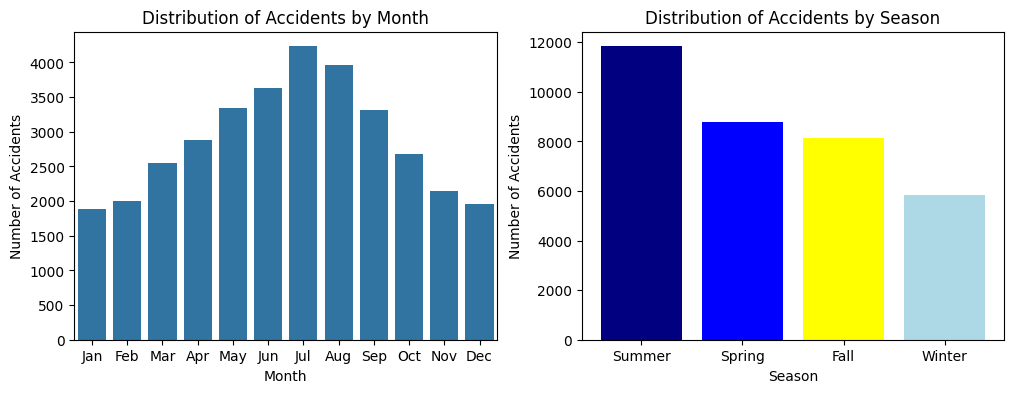

In [105]:
# Plot distribution of accidents by months and seasons

fig, axes = plt.subplots(1, 2, figsize=(12, 4))


sns.countplot(data=dropped_col_df, x='Month', ax=axes[0])
axes[0].set_title('Distribution of Accidents by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Accidents')
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(month_order)


season_colors = {
    'Winter': 'lightblue',
    'Spring': 'blue',
    'Summer': 'navy',
    'Fall': 'yellow'
}


seasonal_accident_counts = dropped_col_df['Season'].value_counts()


axes[1].bar(seasonal_accident_counts.index, seasonal_accident_counts, color=[season_colors.get(season, 'blue') for season in seasonal_accident_counts.index])
axes[1].set_title('Distribution of Accidents by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Accidents')
plt.show()

In [107]:
miesiac_pol = {1: 'Sty', 2:'Lut', 3:'Mar', 4:'Kwi', 5:'Maj', 6:'Cze', 7:'Lip', 8:'Sie', 9:'Wrz', 10:'Paź', 11:'Lis', 12:'Gru'}

dropped_col_df["Miesiąc"] = dropped_col_df["Month"].map(miesiac_pol)

In [115]:
sezon_pol = {'Winter': 'Zima', 'Spring': 'Wiosna', 'Summer': 'Lato', 'Fall':'Jesień'}
dropped_col_df["Season_pol"] = dropped_col_df["Season"].map(sezon_pol)


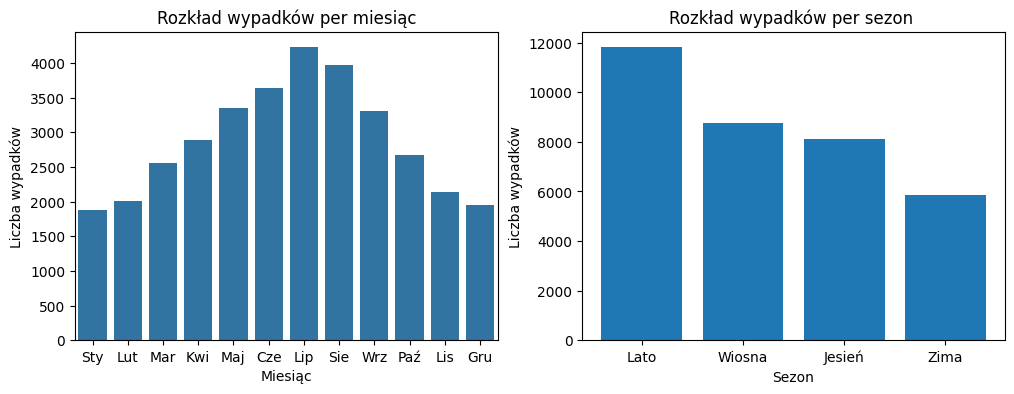

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


sns.countplot(data=dropped_col_df, x='Month', ax=axes[0])
axes[0].set_title('Rozkład wypadków per miesiąc')
axes[0].set_xlabel('Miesiąc')
axes[0].set_ylabel('Liczba wypadków')
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

month_order = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru']
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(month_order)


season_colors = {
    'Winter': 'lightblue',
    'Spring': 'blue',
    'Summer': 'navy',
    'Fall': 'yellow'
}


seasonal_accident_counts = dropped_col_df['Season_pol'].value_counts()


axes[1].bar(seasonal_accident_counts.index, seasonal_accident_counts)
axes[1].set_xlabel('Sezon')
axes[1].set_ylabel('Liczba wypadków')
axes[1].set_title("Rozkład wypadków per sezon ")
plt.show()

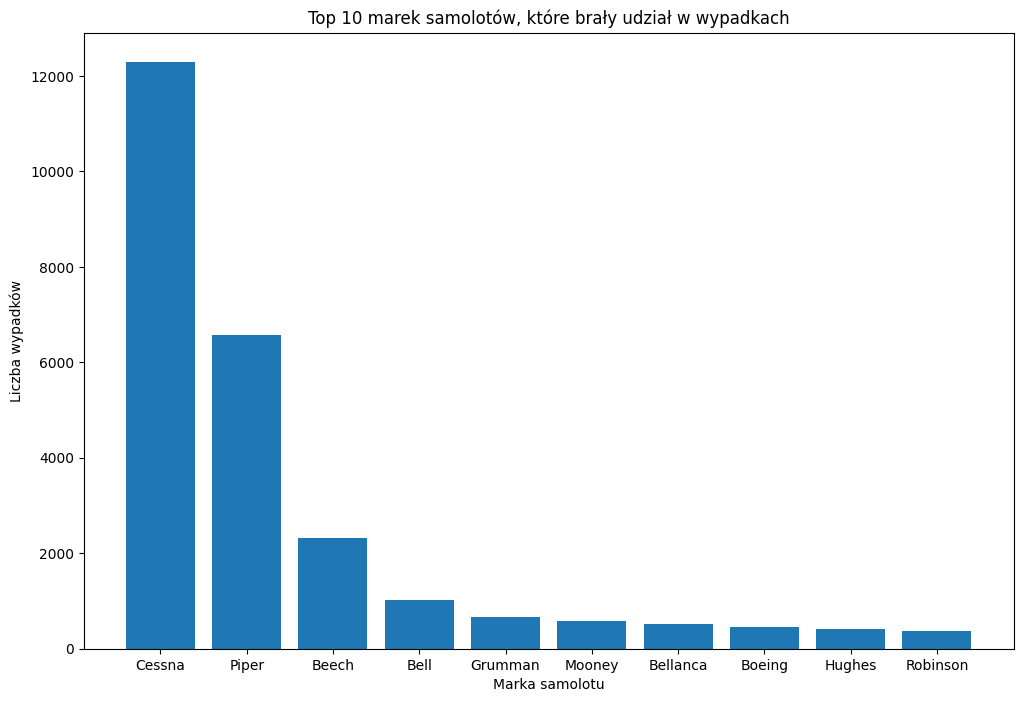

In [129]:
#visualising top 10 Makes 

top_10_makes = dropped_col_df["Make"].value_counts().head(10)

# cmap = cm.get_cmap('Blues', len(top_10_makes))

plt.figure(figsize=(12,8))
plt.bar(top_10_makes.index, top_10_makes.values)

plt.xlabel("Marka samolotu")
plt.ylabel("Liczba wypadków")
plt.title("Top 10 marek samolotów, które brały udział w wypadkach")
plt.show()



In [135]:

dropped_col_df["Broad.phase.of.flight"].value_counts().sum()

34580

In [136]:
dropped_col_df["Broad.phase.of.flight"].value_counts()




Broad.phase.of.flight
Landing        8384
Takeoff        7185
Cruise         5871
Maneuvering    4710
Approach       3643
Climb          1165
Taxi           1077
Descent        1007
Go-around       763
Standing        406
Unknown         307
Other            62
Name: count, dtype: int64

In [148]:
#landing - percentage of accidents


landing = dropped_col_df[dropped_col_df["Broad.phase.of.flight"] =="Landing"]

len(landing) / len(dropped_col_df)

0.24245228455754772

In [149]:
#takeoff - percentage of accidents


takeoff = dropped_col_df[dropped_col_df["Broad.phase.of.flight"] =="Takeoff"]

len(takeoff) / len(dropped_col_df)

0.20777906304222094

In [151]:
#cruise - percentage of accidents


cruise = dropped_col_df[dropped_col_df["Broad.phase.of.flight"] =="Cruise"]

len(cruise) / len(dropped_col_df)

0.1697802197802198

In [156]:
dropped_col_df["Purpose.of.flight"].value_counts()



Purpose.of.flight
Personal                     20029
Instructional                 4494
Unknown                       3689
Aerial Application            2208
Business                      1891
Positioning                    581
Other Work Use                 459
Ferry                          426
Public Aircraft                311
Aerial Observation             262
Executive/corporate            221
Flight Test                      5
Skydiving                        1
Public Aircraft - Local          1
Public Aircraft - Federal        1
Glider Tow                       1
Name: count, dtype: int64

In [ ]:
#personal fligths' percentage

personal = dropped_col_df[dropped_col_df["Purpose.of.flight"] == 'Personal']

len(personal) / len(dropped_col_df)


In [157]:
#instructional fligths' percentage

instructional = dropped_col_df[dropped_col_df["Purpose.of.flight"] == 'Instructional']

len(instructional) / len(dropped_col_df)


0.12995951417004048

In [54]:
dropped_col_df.describe()


,Event.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Death.Ratio,Year
count,34580,34580.000000,34580.000000,34580.000000,34580.000000,34580.000000,34580.000000,34580.000000
mean,1992-05-28 17:38:10.757663488,1.131290,0.413360,0.195084,0.333285,2.764430,0.177499,1991.900839
min,1962-07-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1962.000000
25%,1988-10-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1988.000000
50%,1992-07-03 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1992.000000
75%,1996-07-25 00:00:00,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1996.000000
max,2007-12-30 00:00:00,4.000000,230.000000,81.000000,125.000000,461.000000,1.000000,2007.000000
std,NaN,0.406074,2.519971,0.891557,1.566959,17.278198,0.372164,5.162926


In [159]:
transformed_data.shape


(34580, 56)

In [160]:
# analyzing the total fatal injuries

dropped_col_df["Total.Fatal.Injuries"].describe()

count    34580.000000
mean         0.413360
std          2.519971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        230.000000
Name: Total.Fatal.Injuries, dtype: float64

In [164]:
# The below records refer to one accident that took place in 1996 in Indie. Two planes crashed in the air. 349 is the total number of injuries from both aircrafts. 
# In the analysis it is an outlier.

dropped_col_df[dropped_col_df["Total.Fatal.Injuries"] == 349]

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Death.Ratio,Year,Month,Season,Miesiąc,Season_pol


In [167]:
percentile_99 = np.percentile(dropped_col_df["Total.Fatal.Injuries"], 99)
percentile_99

# In 99% of records the number of casualties is 4 or fewer.

4.0

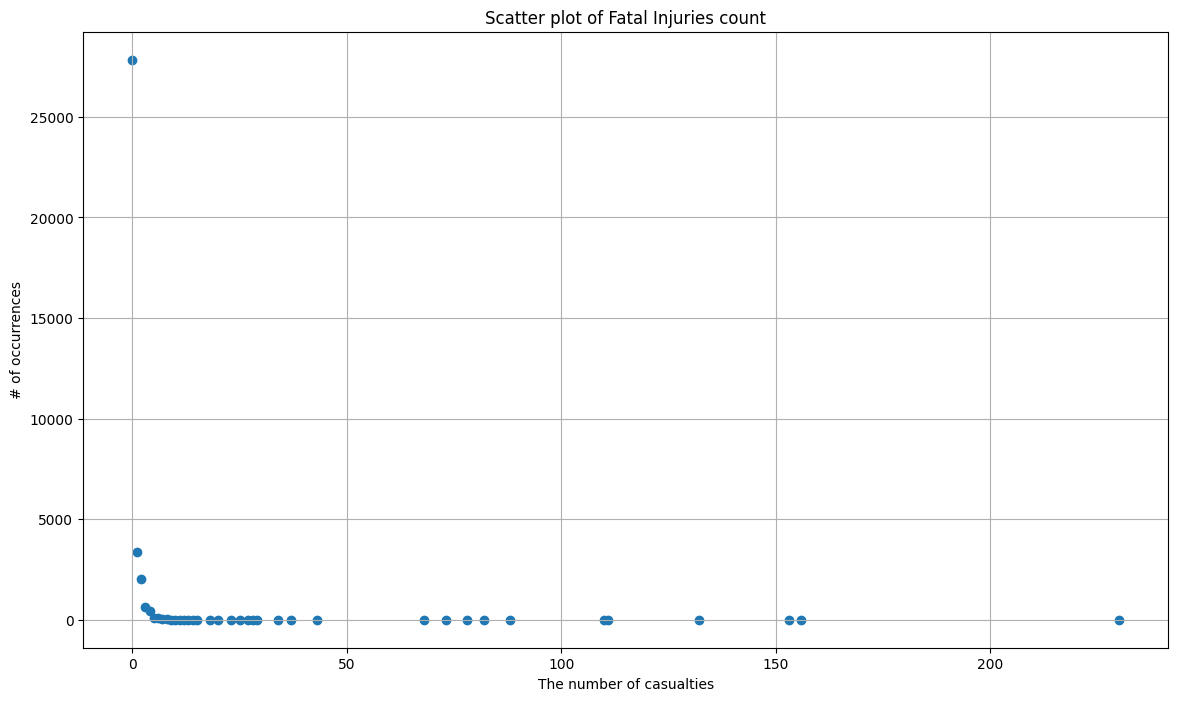

In [168]:
#creating scatter plot to make data more readable / easily visible

counts_fatal = dropped_col_df["Total.Fatal.Injuries"].value_counts()

plt.figure(figsize=(14,8))
plt.scatter(counts_fatal.index, counts_fatal)
plt.xlabel("The number of casualties")
plt.ylabel("# of occurrences")
plt.title("Scatter plot of Fatal Injuries count")
plt.grid()
plt.show()

In [184]:
#removed Year, Event Date, Make, Model - to be considered potentially (ID removed as well)
# Data preprocessing - Pipeline
# preparing data for modelling

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


numeric_features = ["Number.of.Engines", "Total.Fatal.Injuries", "Total.Serious.Injuries", "Total.Minor.Injuries", "Total.Uninjured"]
categorical_features = ["Investigation.Type", "Aircraft.damage", "Amateur.Built", "Number.of.Engines", "Engine.Type", "Purpose.of.flight", "Weather.Condition", "Broad.phase.of.flight", "Report.Status"]

numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy="mean")), ('scaling', StandardScaler())])
categorical_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy="most_frequent")), ('onehot', OneHotEncoder(sparse_output=False))])


transformer = ColumnTransformer(transformers= [('num', numeric_pipeline, numeric_features),
                                               ('cat', categorical_pipeline, categorical_features)],
                                               
                                              )

transformed_data = pd.DataFrame(transformer.fit_transform(dropped_col_df), columns = transformer.get_feature_names_out())

In [186]:
#make sure if y is well defined !!! 

X = transformed_data
y = dropped_col_df["Death.Ratio"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape, X_train.shape, y_test.shape, y_test.shape

((24206, 56), (24206, 56), (10374,), (10374,))

In [187]:
transformed_data

,num__Number.of.Engines,num__Total.Fatal.Injuries,num__Total.Serious.Injuries,num__Total.Minor.Injuries,num__Total.Uninjured,cat__Investigation.Type_Accident,cat__Investigation.Type_Incident,cat__Aircraft.damage_Destroyed,cat__Aircraft.damage_Minor,cat__Aircraft.damage_Substantial,cat__Amateur.Built_No,cat__Amateur.Built_Yes,cat__Number.of.Engines_0.0,cat__Number.of.Engines_1.0,cat__Number.of.Engines_2.0,cat__Number.of.Engines_3.0,cat__Number.of.Engines_4.0,cat__Engine.Type_Reciprocating,cat__Engine.Type_Turbo Fan,cat__Engine.Type_Turbo Jet,cat__Engine.Type_Turbo Prop,cat__Engine.Type_Turbo Shaft,cat__Engine.Type_Unknown,cat__Purpose.of.flight_Aerial Application,cat__Purpose.of.flight_Aerial Observation,cat__Purpose.of.flight_Business,cat__Purpose.of.flight_Executive/corporate,cat__Purpose.of.flight_Ferry,cat__Purpose.of.flight_Flight Test,cat__Purpose.of.flight_Glider Tow,cat__Purpose.of.flight_Instructional,cat__Purpose.of.flight_Other Work Use,cat__Purpose.of.flight_Personal,cat__Purpose.of.flight_Positioning,cat__Purpose.of.flight_Public Aircraft,cat__Purpose.of.flight_Public Aircraft - Federal,cat__Purpose.of.flight_Public Aircraft - Local,cat__Purpose.of.flight_Skydiving,cat__Purpose.of.flight_Unknown,cat__Weather.Condition_IMC,cat__Weather.Condition_UNK,cat__Weather.Condition_VMC,cat__Broad.phase.of.flight_Approach,cat__Broad.phase.of.flight_Climb,cat__Broad.phase.of.flight_Cruise,cat__Broad.phase.of.flight_Descent,cat__Broad.phase.of.flight_Go-around,cat__Broad.phase.of.flight_Landing,cat__Broad.phase.of.flight_Maneuvering,cat__Broad.phase.of.flight_Other,cat__Broad.phase.of.flight_Standing,cat__Broad.phase.of.flight_Takeoff,cat__Broad.phase.of.flight_Taxi,cat__Broad.phase.of.flight_Unknown,cat__Report.Status_Foreign,cat__Report.Status_Probable Cause
0,-0.323319,1.423307,-0.218816,-0.212699,-0.159998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.323319,0.629635,-0.218816,-0.212699,-0.159998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.323319,1.423307,-0.218816,-0.212699,-0.159998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.323319,-0.164036,-0.218816,-0.212699,-0.044243,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2.139321,-0.164036,-0.218816,-0.212699,-0.044243,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34575,-0.323319,-0.164036,-0.218816,1.063678,-0.159998,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34576,-0.323319,-0.164036,-0.218816,-0.212699,0.071511,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34577,-0.323319,-0.164036,0.902833,-0.212699,-0.159998,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

In [188]:
# creating a model to predict fatal injuries 

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [189]:
y_pred_reg = reg_model.predict(X_test)

In [ ]:
#ratios mae, mape

